In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Set up
import sys

sys.path.append("/home/dchen/BA_CH_EN/")

# Basics
import tensorflow as tf
import xarray as xr
import numpy as np
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_preds import *
from src.models.DRN.DRN_load_preds_dummy_10 import *
from src.models.EMOS_local.EMOS_local_load_preds import *  # Load EMOS_global_preds
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_preds import *  # Load EMOS_global_preds
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores

<IPython.core.display.Javascript object>

### 1. Load Predictions:

In [4]:
# # EMOS_global
# EMOS_global_t2m_preds = EMOS_global_load_preds("t2m")
# EMOS_global_ws10_preds = EMOS_global_load_preds("ws10")

# # EMOS_global
# EMOS_local_t2m_preds = EMOS_local_load_preds("t2m")
# EMOS_local_ws10_preds = EMOS_local_load_preds("ws10")

# EMOS_global
DRN_t2m_preds = DRN_load_preds_dummy_10("t2m")
DRN_ws10_preds = DRN_load_preds_dummy_10("ws10")

<IPython.core.display.Javascript object>

### 2. Load Matching Ground truth values 

In [10]:
t2m_ground_truth = ldpd.load_data_all_test_proc_denorm()[2].t2m_test_truth
ws10_ground_truth = ldpd.load_data_all_test_proc_denorm()[5].ws10_test_truth

<IPython.core.display.Javascript object>

In [13]:
t2m_ground_truth

<xarray.DataArray 't2m_test_truth' (forecast_date: 357, lead_time: 32,
                                    lat: 120, lon: 130)>
[178214400 values with dtype=float32]
Dimensions without coordinates: forecast_date, lead_time, lat, lon

<IPython.core.display.Javascript object>

In [9]:
len(DRN_t2m_preds)

31

<IPython.core.display.Javascript object>

In [8]:
DRN_t2m_preds[0].shape

(357, 120, 130, 2)

<IPython.core.display.Javascript object>

In [11]:
t2m_ground_truth

<xarray.DataArray 't2m_test_truth' (forecast_date: 357, lead_time: 32,
                                    lat: 120, lon: 130)>
[178214400 values with dtype=float32]
Dimensions without coordinates: forecast_date, lead_time, lat, lon

<IPython.core.display.Javascript object>

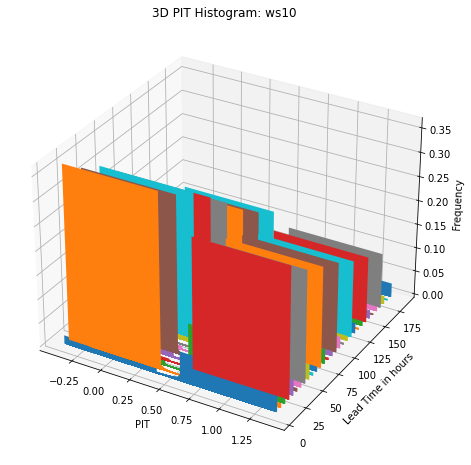

<IPython.core.display.Javascript object>

In [15]:
plot_pit_histogram(DRN_t2m_preds, t2m_ground_truth)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import norm

def plot_pit_histogram(predicted_mean_sd, ground_truth):
    """
    Plots a 3D PIT histogram for probabilistic forecasts.

    Parameters
    ----------
    predicted_mean_sd : list of numpy.ndarray
        A list of numpy.ndarrays containing the predicted means and standard deviations. Each numpy.ndarray should have the dimensions
        ('forecast_date', 'lat', 'lon', 'parameter') where parameter 0 is the mean and parameter 1 is the standard deviation.
    ground_truth : xarray.DataArray
        An xarray DataArray containing the ground truth values with the dimensions
        ('forecast_date', 'lead_time', 'lat', 'lon').

    Returns
    -------
    None
        This function doesn't return a value. It directly plots the 3D PIT histogram.

    Raises
    ------
    AssertionError
        If the inputs are not a list of numpy.ndarrays and an xarray DataArray respectively.
    """
    # Ensure the input data are a list of numpy.ndarrays and an xarray DataArray
    assert isinstance(predicted_mean_sd, list)
    assert isinstance(ground_truth, xr.DataArray)
    assert all(isinstance(arr, np.ndarray) for arr in predicted_mean_sd)

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Initialize the maximum frequency
    max_frequency = 0

    # Loop through each lead time
    for lead_time_idx, mean_sd_array in enumerate(predicted_mean_sd):
        # Get the mean and standard deviation arrays
        mean_array = mean_sd_array[..., 0]
        sd_array = np.abs(mean_sd_array[..., 1])

        # Get the corresponding ground truth data for this lead time
        ground_truth_data = ground_truth.sel(lead_time=lead_time_idx + 1)

        # Calculate the PIT values
        pits = norm.cdf(ground_truth_data.values, loc=mean_array, scale=sd_array)

        # Compute the histogram
        hist, bin_edges = np.histogram(pits.flatten(), bins=np.linspace(0, 1, len(mean_sd_array) + 1), density=False)

        # Normalize the histogram
        hist = hist / hist.sum()

        # Update the maximum frequency if necessary
        max_frequency = max(max_frequency, hist.max())

        # Plot the histogram as a 3D bar plot
        xs = bin_edges[:-1]
        ys = hist
        zs = np.full_like(xs, (lead_time_idx + 1) * 6)
        ax.bar(xs, ys, zs=zs, zdir="y", alpha=1)

    # Set plot labels and title
    ax.set_xlabel("PIT")
    ax.set_ylabel("Lead Time in hours")
    ax.set_zlabel("Frequency")
    ax.set_title("3D PIT Histogram: t2m")

    # Set the z-axis limits to match the maximum normalized frequency
    ax.set_zlim(0, max_frequency)

    # Show the plot
    plt.show()

<IPython.core.display.Javascript object>

In [23]:
DRN_t2m_preds[0].shape

(357, 120, 130, 2)

<IPython.core.display.Javascript object>

In [25]:
DRN_t2m_preds[0].reshape(-1, 2).shape

(5569200, 2)

<IPython.core.display.Javascript object>

In [26]:
t2m_ground_truth.isel(lead_time = 1)

<xarray.DataArray 't2m_test_truth' (forecast_date: 357, lead_time: 32,
                                    lat: 120, lon: 130)>
[178214400 values with dtype=float32]
Dimensions without coordinates: forecast_date, lead_time, lat, lon

<IPython.core.display.Javascript object>